# Imports

In [420]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import biosppy.signals.ecg as ecg
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout, Embedding
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import class_weight

# Data

In [198]:
x_train = pd.read_csv('../data/X_train.csv').drop('id', axis=1)

In [199]:
y_train = pd.read_csv('../data/y_train.csv').drop('id', axis=1)

In [194]:
x_test = pd.read_csv('../data/X_test.csv').drop('id', axis=1)

In [200]:
sampling_rate=300

In [203]:
"""
Extracts heartbeats from one row of the input data. Also scales data to between 0 and 1
"""
def get_heartbeats(data):
    signal = data[~np.isnan(data)]
    signal = np.interp(signal, (signal.min(), signal.max()), (0, 1))
    rpeaks = ecg.christov_segmenter(signal=signal, sampling_rate=sampling_rate)[0]
    beats = ecg.extract_heartbeats(signal=signal,rpeaks=rpeaks,sampling_rate=sampling_rate)
    return beats[0]

"""
Creates training data where every row is an individual heartbeat
"""
def create_training_data(x_train, y_train):
    X = np.empty((0,180))
    y = np.array([])
    for i in range(0, x_train.shape[0]):
        if i % 100 == 0:
            print(i)
        beats = get_heartbeats(x_train.iloc[i].values)
        if beats.shape[0] == 0: # some rows gave back 0 beats for some reason ? 
            print('0 shape, row {}, class {}'.format(i, y_train.y[i]))
            continue
        X = np.append(X, beats, axis=0)
        classes = np.full((beats.shape[0], 1), y_train.y[i])
        y = np.append(y, classes)
    return X, y

In [204]:
X, y = create_training_data(x_train, y_train)

0
100
200
300
0 shape, row 333, class 3
400
0 shape, row 429, class 2
500
600
700
800
900
1000
1100
0 shape, row 1101, class 1
1200
1300
1400
0 shape, row 1474, class 2
1500
1600
1700
1800
1900
2000
2100
2200
0 shape, row 2292, class 0
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
0 shape, row 3784, class 0
3800
0 shape, row 3871, class 3
3900
4000
4100
4200
0 shape, row 4253, class 0
4300
4400
0 shape, row 4400, class 2
4500
4600
4700
4800
4900
5000
5100


In [205]:
X.shape

(177230, 180)

In [206]:
y.shape

(177230,)

In [207]:
unique, counts = np.unique(y, return_counts=True)
counts

array([100965,  18776,  54122,   3367])

In [208]:
xdf = pd.DataFrame(X)
ydf = pd.DataFrame(y)

In [209]:
ydf[0].value_counts()

0.0    100965
2.0     54122
1.0     18776
3.0      3367
Name: 0, dtype: int64

In [210]:
x0 = xdf[ydf[0] == 0]
x1 = xdf[ydf[0] == 1]
x2 = xdf[ydf[0] == 2]
x3 = xdf[ydf[0] == 3]

In [211]:
x0.shape

(100965, 180)

In [440]:
# get 7000 samples of each class
state = 1234
n_samples = 10000
x0new = resample(x0,replace=False,n_samples=8000,random_state=state)
x1new = resample(x1,replace=True,n_samples=8000,random_state=state)
x2new = resample(x2,replace=False,n_samples=8000,random_state=state)
x3new = resample(x3,replace=True,n_samples=8000,random_state=state)

In [441]:
X_balanced = pd.concat([x0new, x1new, x2new, x3new])
y_balanced = pd.concat([pd.DataFrame(np.full((len(x0new)),0)),
                            pd.DataFrame(np.full((len(x1new)),1)),
                            pd.DataFrame(np.full((len(x2new)),2)),
                            pd.DataFrame(np.full((len(x3new)),3))])

In [442]:
Xtr, Xtest, ytr, ytest = train_test_split(X_balanced, to_categorical(y_balanced), test_size=0.2, random_state=state)

In [443]:
cw = class_weight.compute_class_weight('balanced', np.unique(y_balanced), y_balanced[0].values.ravel())
weights = dict(enumerate(cw))

## Class weights

In [255]:
Xtr, Xtest, ytr, ytest = train_test_split(xdf, to_categorical(ydf), test_size=0.2, random_state=state)

In [380]:
cw = class_weight.compute_class_weight('balanced', np.unique(ydf[0]), ydf)

/Users/elrich/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [257]:
cw

array([ 0.43884019,  2.35979442,  0.81865969, 13.15934066])

In [258]:
weights = dict(enumerate(cw))

# Model

In [444]:
model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(180,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

history = model.fit(Xtr, ytr, epochs=200, batch_size=128, validation_data=(Xtest,ytest), class_weight=weights)

Train on 25600 samples, validate on 6400 samples
Epoch 1/200
25600/25600 [==============================] - 1s 27us/step - loss: 1.2081 - categorical_accuracy: 0.4479 - val_loss: 1.1461 - val_categorical_accuracy: 0.4784
Epoch 2/200
25600/25600 [==============================] - 0s 18us/step - loss: 1.1141 - categorical_accuracy: 0.5017 - val_loss: 1.1013 - val_categorical_accuracy: 0.5041
Epoch 3/200
25600/25600 [==============================] - 0s 18us/step - loss: 1.0820 - categorical_accuracy: 0.5198 - val_loss: 1.0616 - val_categorical_accuracy: 0.5334
Epoch 4/200
25600/25600 [==============================] - 0s 19us/step - loss: 1.0583 - categorical_accuracy: 0.5361 - val_loss: 1.0767 - val_categorical_accuracy: 0.5275
Epoch 5/200
25600/25600 [==============================] - 0s 19us/step - loss: 1.0400 - categorical_accuracy: 0.5474 - val_loss: 1.0566 - val_categorical_accuracy: 0.5348
Epoch 6/200
25600/25600 [==============================] - 0s 18us/step - loss: 1.0244 - ca

25600/25600 [==============================] - 0s 18us/step - loss: 0.7765 - categorical_accuracy: 0.6747 - val_loss: 0.8392 - val_categorical_accuracy: 0.6570
Epoch 49/200
25600/25600 [==============================] - 0s 19us/step - loss: 0.7746 - categorical_accuracy: 0.6766 - val_loss: 0.8477 - val_categorical_accuracy: 0.6453
Epoch 50/200
25600/25600 [==============================] - 0s 19us/step - loss: 0.7789 - categorical_accuracy: 0.6752 - val_loss: 0.8461 - val_categorical_accuracy: 0.6481
Epoch 51/200
25600/25600 [==============================] - 0s 19us/step - loss: 0.7704 - categorical_accuracy: 0.6743 - val_loss: 0.8720 - val_categorical_accuracy: 0.6370
Epoch 52/200
25600/25600 [==============================] - 0s 19us/step - loss: 0.7632 - categorical_accuracy: 0.6814 - val_loss: 0.8449 - val_categorical_accuracy: 0.6463
Epoch 53/200
25600/25600 [==============================] - 0s 19us/step - loss: 0.7584 - categorical_accuracy: 0.6832 - val_loss: 0.8776 - val_cate

25600/25600 [==============================] - 0s 18us/step - loss: 0.6268 - categorical_accuracy: 0.7400 - val_loss: 0.8060 - val_categorical_accuracy: 0.6844
Epoch 96/200
25600/25600 [==============================] - 0s 19us/step - loss: 0.6413 - categorical_accuracy: 0.7346 - val_loss: 0.8158 - val_categorical_accuracy: 0.6752
Epoch 97/200
25600/25600 [==============================] - 0s 19us/step - loss: 0.6307 - categorical_accuracy: 0.7375 - val_loss: 0.8044 - val_categorical_accuracy: 0.6867
Epoch 98/200
25600/25600 [==============================] - 0s 18us/step - loss: 0.6242 - categorical_accuracy: 0.7416 - val_loss: 0.8104 - val_categorical_accuracy: 0.6777
Epoch 99/200
25600/25600 [==============================] - 0s 19us/step - loss: 0.6200 - categorical_accuracy: 0.7408 - val_loss: 0.7924 - val_categorical_accuracy: 0.7005
Epoch 100/200
25600/25600 [==============================] - 0s 18us/step - loss: 0.6256 - categorical_accuracy: 0.7437 - val_loss: 0.8015 - val_cat

25600/25600 [==============================] - 0s 17us/step - loss: 0.5499 - categorical_accuracy: 0.7750 - val_loss: 0.8288 - val_categorical_accuracy: 0.7006
Epoch 143/200
25600/25600 [==============================] - 0s 18us/step - loss: 0.5501 - categorical_accuracy: 0.7722 - val_loss: 0.8155 - val_categorical_accuracy: 0.7041
Epoch 144/200
25600/25600 [==============================] - 0s 18us/step - loss: 0.5484 - categorical_accuracy: 0.7745 - val_loss: 0.8247 - val_categorical_accuracy: 0.7053
Epoch 145/200
25600/25600 [==============================] - 0s 18us/step - loss: 0.5423 - categorical_accuracy: 0.7775 - val_loss: 0.8222 - val_categorical_accuracy: 0.7034
Epoch 146/200
25600/25600 [==============================] - 0s 18us/step - loss: 0.5370 - categorical_accuracy: 0.7780 - val_loss: 0.8130 - val_categorical_accuracy: 0.7120
Epoch 147/200
25600/25600 [==============================] - 0s 18us/step - loss: 0.5393 - categorical_accuracy: 0.7782 - val_loss: 0.8258 - val

25600/25600 [==============================] - 0s 18us/step - loss: 0.4937 - categorical_accuracy: 0.7994 - val_loss: 0.8196 - val_categorical_accuracy: 0.7128
Epoch 190/200
25600/25600 [==============================] - 0s 19us/step - loss: 0.4867 - categorical_accuracy: 0.8037 - val_loss: 0.8278 - val_categorical_accuracy: 0.7220
Epoch 191/200
25600/25600 [==============================] - 0s 19us/step - loss: 0.4884 - categorical_accuracy: 0.8032 - val_loss: 0.8374 - val_categorical_accuracy: 0.7123
Epoch 192/200
25600/25600 [==============================] - 0s 19us/step - loss: 0.4753 - categorical_accuracy: 0.8063 - val_loss: 0.8394 - val_categorical_accuracy: 0.7133
Epoch 193/200
25600/25600 [==============================] - 0s 19us/step - loss: 0.4884 - categorical_accuracy: 0.8016 - val_loss: 0.8247 - val_categorical_accuracy: 0.7227
Epoch 194/200
25600/25600 [==============================] - 0s 19us/step - loss: 0.4921 - categorical_accuracy: 0.8004 - val_loss: 0.8147 - val

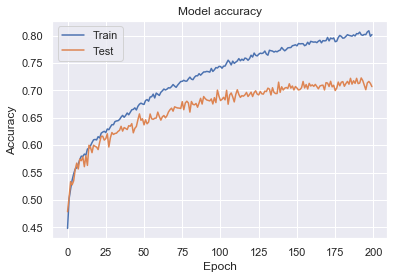

In [445]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

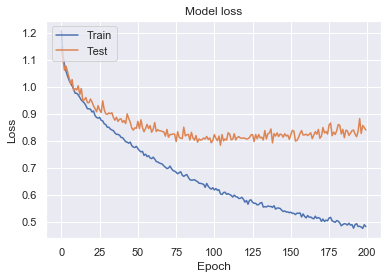

In [446]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [447]:
ypred = model.predict_classes(Xtest)
ytrue = np.argmax(ytest, axis=1)

In [448]:
f1_score(ytrue, ypred, average='micro')

0.706875

# Output predictions

In [307]:
"""
Creates testing data where every row is an individual heartbeat
"""
def create_testing_data(x_test):
    X = []
    for i in range(0, x_test.shape[0]):
        if i % 100 == 0:
            print(i)
        beats = get_heartbeats(x_test.iloc[i].values)
        if beats.shape[0] == 0: # some rows gave back 0 beats for some reason ? 
            print('0 shape, row {}'.format(i))
#             continue
        X.append(beats)
    return X

In [309]:
X_test = create_testing_data(x_test)

0
100
200
0 shape, row 254
300
400
0 shape, row 437
500
600
700
800
900
1000
0 shape, row 1056
1100
0 shape, row 1107
1200
0 shape, row 1225
1300
0 shape, row 1355
1400
1500
1600
0 shape, row 1655
1700
1800
1900
2000
2100
0 shape, row 2127
2200
2300
0 shape, row 2351
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
0 shape, row 3345
3400


In [321]:
np.save('x_test.npy', X_test_np)

In [323]:
np.save('x_train.npy', x_train)

In [324]:
np.save('y_train.npy', y_train)

In [350]:
def get_predictions(model):
    y_pred = []
    for i in range(0,len(X_test)):
        x = X_test[i]
        if len(x) == 0:
            print('no pred')
            y_pred.append(0)
            continue
        pred = model.predict_classes(X_test[i])
        counts = np.bincount(pred)
        y_pred.append(np.argmax(counts))
    return y_pred

def output_pred(preds, name):
    output = pd.DataFrame({'id':[float(i) for i in range(0, len(preds))], 'y': preds})
    output.to_csv(name,index=False)

In [361]:
preds = get_predictions(model)

no pred
no pred
no pred
no pred
no pred
no pred
no pred
no pred
no pred
no pred


In [362]:
output_pred(preds, 'nn1.csv')